In [46]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)

val_dataset = datasets.MNIST('./data', train=False, transform=transform, download=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=32)

(5, torch.Size([1, 28, 28]))

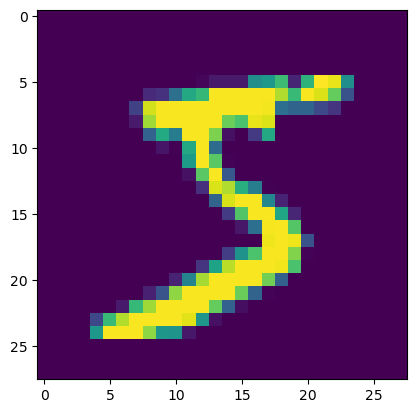

In [130]:
img, label = train_dataset[0]

plt.imshow(img[0])
img_sz = img.shape[-1]
label, img.shape

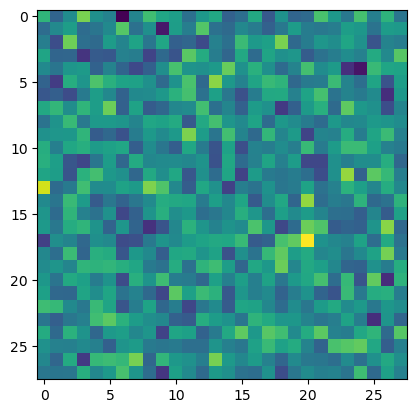

In [150]:
class VAEModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(img_sz * img_sz, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
        )
        
        self.mean_head = nn.Linear(64, 8)
        self.logvar_head = nn.Linear(64, 8)

        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            #
            nn.Linear(64, img_sz * img_sz),
            nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor):
        x = self.flatten(x)
        encoded = self.encoder(x)
        
        mue = self.mean_head(encoded)
        logvar = self.logvar_head(encoded)
        eps = torch.randn_like(mue)
        
        z = mue + torch.exp(logvar * 0.5) * eps
        
        decoded = self.decoder(z)

        return decoded, (encoded, mue, logvar)


model = VAEModel()
model.eval()
img_pred = model(train_dataset[0][0])[0].view(-1, img_sz, img_sz)
plt.imshow(img_pred[0].detach())

In [151]:
avg_train_losses = []
avg_val_losses = []
recon_losses = []
kl_losses = []

In [152]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-2)
reconstruct_criterion = nn.BCELoss(reduction='sum')

In [153]:
def vae_criterion(preds, targets, logvar, mue):
    recon_loss = reconstruct_criterion(preds, targets)
    var = torch.exp(logvar)
    kl_loss = 0.5 * torch.sum(-logvar - 1 + var + mue**2)

    recon_losses.append(recon_loss.item() / targets.shape[0])
    kl_losses.append(kl_loss.item() / targets.shape[0])

    return (recon_loss + kl_loss) / targets.shape[0]


epochs = 30

accum_steps = 30

try:
    for epoch in range(epochs):
        model.train()
        avg_train_loss = 0
        train_bar = tqdm(train_loader, desc="Training")

        opt.zero_grad()
        for i, (x, y) in enumerate(train_bar):
            x = x.squeeze(1)
            x_pred, (encoded, logvar, mue) = model(x)

            loss = vae_criterion(x_pred, x.view(-1, img_sz * img_sz), logvar, mue)
            avg_train_loss += loss.item()
            (loss / accum_steps).backward()

            if (i + 1) % accum_steps == 0:
                opt.step()
                opt.zero_grad()

            train_bar.set_postfix(loss=avg_train_loss / (i + 1))

        avg_train_loss /= len(train_loader)

        # Validate
        model.eval()
        avg_val_loss = 0
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc="Validation"):
                x = x.squeeze(1)
                y_pred, (encoded, logvar, mue) = model(x)

                loss = vae_criterion(y_pred, x.view(-1, img_sz * img_sz), logvar, mue)
                avg_val_loss += loss.item()

        avg_val_loss /= len(val_loader)

        avg_train_losses.append(avg_train_loss)
        avg_val_losses.append(avg_val_loss)

        print(f"EPOCH {epoch}, Avg Train loss: {avg_train_loss}, Avg Val Loss: {avg_val_loss}")

except KeyboardInterrupt:
    print("tired of waiting..")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 0, Avg Train loss: 202.16554684244792, Avg Val Loss: 142.56266994293506


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 1, Avg Train loss: 141.93925113932292, Avg Val Loss: 133.66211139813018


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 2, Avg Train loss: 136.7439707356771, Avg Val Loss: 130.28658882116738


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 3, Avg Train loss: 134.4354239013672, Avg Val Loss: 128.39787460668398


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

tired of waiting..


Text(0.5, 1.0, 'total losses')

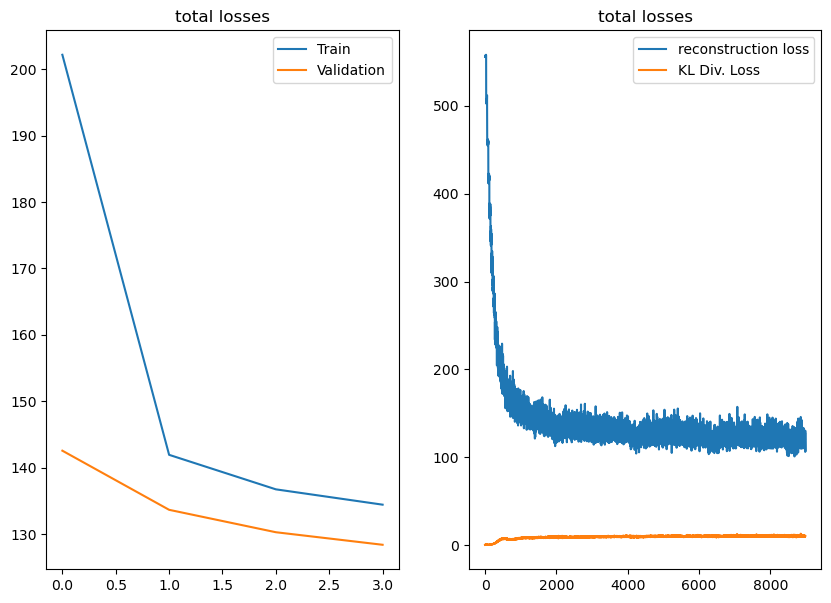

In [154]:
plt.figure(figsize=(10, 7))

plt.subplot(121)
plt.plot(avg_train_losses, label="Train")
plt.plot(avg_val_losses, label="Validation")
plt.legend()
plt.title("total losses")

plt.subplot(122)
plt.plot(recon_losses, label="reconstruction loss")
plt.plot(kl_losses, label="KL Div. Loss")
plt.legend()
plt.title("total losses")

(tensor([[-3.7763, -3.1274,  1.6166, -3.8423,  1.0707, -2.5381, -4.4418,  0.4293]],
        grad_fn=<AddmmBackward0>),
 tensor([[-0.6686, -0.6173, -0.6895, -0.7190, -0.6861, -0.8209, -0.8105, -0.7011]],
        grad_fn=<AddmmBackward0>))

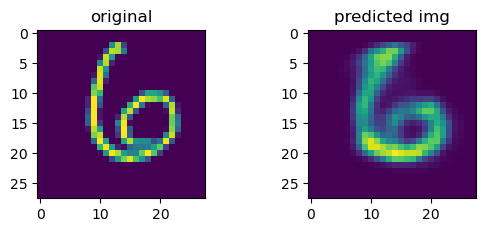

In [165]:
model.eval()
img, _ = val_dataset[100]
img_decoded, (encoded, mue, std) = model(img)
img_pred = img_decoded.view(-1, img_sz, img_sz).detach().numpy()

plt.subplot(221)
plt.imshow(img[0].numpy())
plt.title("original")

plt.subplot(222)
plt.imshow(img_pred[0])
plt.title("predicted img")

mue, std

In [166]:
latent_vectors = [[] for _ in range(10)]

for i in range(1000):
    img, label = val_dataset[i]
    img_pred, (encoded, mue, logvar) = model(img)
    
    latent_vectors[label].append(mue[0].detach().numpy())

Visualiztion now is meaningless.. unless the encoder out dim is 2d.. or maybe somewhat 3d idk? maaaaybe
damn why cant' we see 8D :(


Text(0.5, 1.0, 'Latent Space')

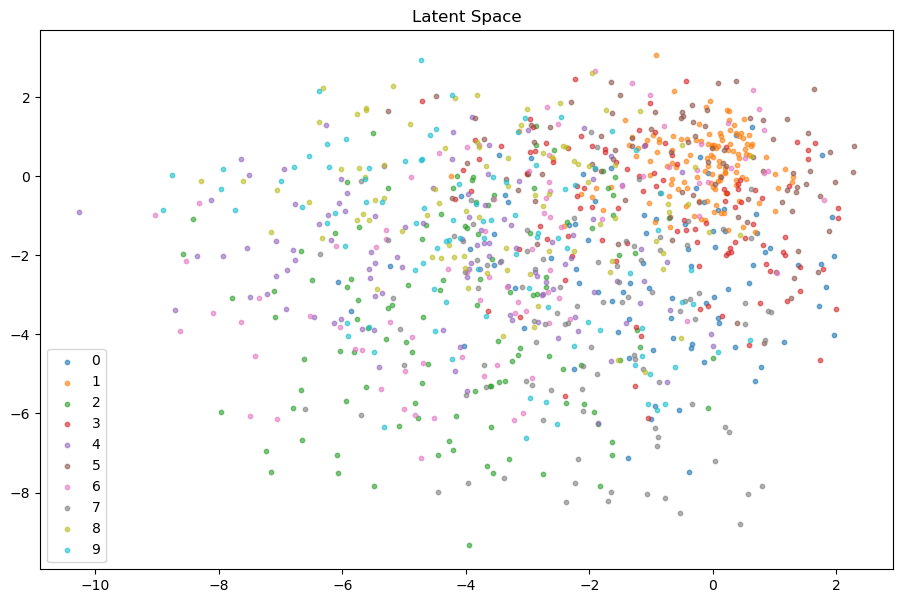

In [169]:
print("Visualiztion now is meaningless.. unless the encoder out dim is 2d.. or maybe somewhat 3d idk? maaaaybe")
print("damn why cant' we see 8D :(")
plt.figure(figsize=(11, 7))
for label, points in enumerate(latent_vectors):
    points = np.array(points)
    plt.scatter(x = points[:, 0], y=points[:, 1], label=label, s=10, alpha=0.6)
    

plt.legend()
plt.title("Latent Space")

(28, 28)


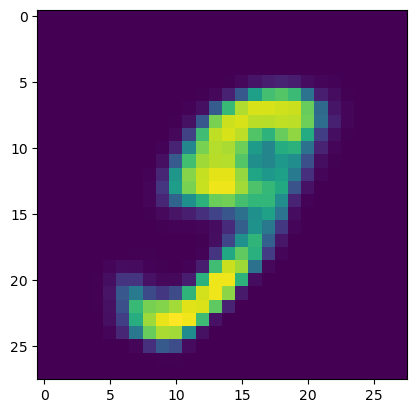

In [171]:
dec = model.decoder
mue =torch.tensor([5.9419, -3.5011, -5.0702, -1.8013,  -5.2777, -3.6911,  1.9615, -2.1640], dtype=torch.float32) 
std = torch.tensor([0] * 8, dtype=torch.float32)

z = (mue + std)[None]

img = dec(z)[0].view(img_sz, img_sz).detach().numpy()

print(img.shape)
plt.imshow(img)